In [ ]:
#13.3.2 GAN 구현하기

In [1]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 512
epochs = 200
sample_size = 64 
nz = 128 
k = 1 

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 299813309.42it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42178166.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 171669845.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5381505.30it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
class Generator(nn.Module):  # 
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3), # 30%의 확률 
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [7]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] 
losses_d = [] 
images = [] 

In [8]:
def save_generator_image(image, path):
    save_image(image, path)

In [9]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [10]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)    
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [11]:
!mkdir img #img 폴더 만들기

In [12]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):                                
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, "./img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx 
    epoch_loss_d = loss_d / idx 
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:15,  7.53it/s]                         

Epoch 0 of 200
Generator loss: 1.43767178, Discriminator loss: 0.89572835



118it [00:13,  8.98it/s]                         

Epoch 1 of 200
Generator loss: 2.42649794, Discriminator loss: 1.38149095



118it [00:13,  8.87it/s]                         

Epoch 2 of 200
Generator loss: 4.00930548, Discriminator loss: 0.55598879



118it [00:12,  9.10it/s]                         

Epoch 3 of 200
Generator loss: 1.12918282, Discriminator loss: 1.50964057



118it [00:13,  9.01it/s]                         

Epoch 4 of 200
Generator loss: 1.07716715, Discriminator loss: 1.18315053



118it [00:12,  9.10it/s]                         

Epoch 5 of 200
Generator loss: 1.36237228, Discriminator loss: 1.07026482



118it [00:13,  8.94it/s]                         

Epoch 6 of 200
Generator loss: 1.75612915, Discriminator loss: 1.03789997



118it [00:13,  8.98it/s]                         

Epoch 7 of 200
Generator loss: 1.52296364, Discriminator loss: 1.02978146



118it [00:12,  9.10it/s]                         

Epoch 8 of 200
Generator loss: 1.89236808, Discriminator loss: 1.07737529



118it [00:13,  9.05it/s]                         

Epoch 9 of 200
Generator loss: 1.25738776, Discriminator loss: 1.46677804



118it [00:13,  8.96it/s]                         

Epoch 10 of 200
Generator loss: 0.89720249, Discriminator loss: 1.19525659



118it [00:13,  8.81it/s]                         

Epoch 11 of 200
Generator loss: 1.27260029, Discriminator loss: 0.91180289



118it [00:13,  8.92it/s]                         


Epoch 12 of 200
Generator loss: 1.98435998, Discriminator loss: 0.80042022


118it [00:13,  8.81it/s]                         


Epoch 13 of 200
Generator loss: 2.86843848, Discriminator loss: 0.64086235


118it [00:14,  8.26it/s]

Epoch 14 of 200
Generator loss: 2.59728885, Discriminator loss: 0.66443783



118it [00:16,  7.15it/s]                         


Epoch 15 of 200
Generator loss: 2.49518752, Discriminator loss: 0.59021837


118it [00:13,  8.89it/s]                         

Epoch 16 of 200
Generator loss: 2.44271922, Discriminator loss: 0.73926449



118it [00:13,  8.95it/s]                         

Epoch 17 of 200
Generator loss: 2.45685029, Discriminator loss: 0.46721417



118it [00:13,  8.92it/s]                         

Epoch 18 of 200
Generator loss: 3.18744659, Discriminator loss: 0.64359272



118it [00:13,  9.02it/s]                         

Epoch 19 of 200
Generator loss: 2.71505713, Discriminator loss: 0.66250008



118it [00:13,  8.89it/s]                         

Epoch 20 of 200
Generator loss: 2.68006253, Discriminator loss: 0.64462405



118it [00:13,  9.02it/s]                         

Epoch 21 of 200
Generator loss: 2.86840868, Discriminator loss: 0.49512148



118it [00:13,  8.89it/s]                         

Epoch 22 of 200
Generator loss: 2.80254722, Discriminator loss: 0.51505423



118it [00:13,  8.51it/s]                         

Epoch 23 of 200
Generator loss: 3.04188180, Discriminator loss: 0.44331047



118it [00:13,  8.89it/s]                         

Epoch 24 of 200
Generator loss: 2.68425941, Discriminator loss: 0.62327957



118it [00:13,  8.98it/s]                         

Epoch 25 of 200
Generator loss: 2.50613046, Discriminator loss: 0.70949459



118it [00:13,  8.97it/s]                         

Epoch 26 of 200
Generator loss: 2.76271439, Discriminator loss: 0.55957133



118it [00:13,  8.77it/s]                         

Epoch 27 of 200
Generator loss: 2.87320685, Discriminator loss: 0.50154591



118it [00:13,  8.74it/s]                         

Epoch 28 of 200
Generator loss: 2.80143499, Discriminator loss: 0.60773373



118it [00:13,  8.61it/s]                         

Epoch 29 of 200
Generator loss: 2.55425215, Discriminator loss: 0.65119815



118it [00:13,  8.84it/s]                         

Epoch 30 of 200
Generator loss: 3.97897482, Discriminator loss: 2.61011624



118it [00:13,  8.64it/s]                         

Epoch 31 of 200
Generator loss: 11.20366573, Discriminator loss: 0.72965205



118it [00:13,  8.44it/s]                         

Epoch 32 of 200
Generator loss: 3.14896894, Discriminator loss: 0.61722189



118it [00:15,  7.85it/s]                         

Epoch 33 of 200
Generator loss: 3.10075736, Discriminator loss: 0.60204279



118it [00:13,  8.72it/s]                         

Epoch 34 of 200
Generator loss: 3.15041018, Discriminator loss: 0.74179053



118it [00:13,  8.90it/s]                         

Epoch 35 of 200
Generator loss: 2.46034288, Discriminator loss: 0.65066558



118it [00:13,  8.84it/s]                         

Epoch 36 of 200
Generator loss: 2.45909643, Discriminator loss: 0.67717057



118it [00:13,  8.82it/s]                         

Epoch 37 of 200
Generator loss: 2.93811035, Discriminator loss: 0.55526620



118it [00:13,  8.73it/s]                         

Epoch 38 of 200
Generator loss: 2.81336784, Discriminator loss: 0.48167363



118it [00:13,  8.88it/s]                         

Epoch 39 of 200
Generator loss: 2.74418306, Discriminator loss: 0.57355428



118it [00:13,  8.64it/s]                         

Epoch 40 of 200
Generator loss: 2.39231920, Discriminator loss: 0.68098336



118it [00:13,  8.76it/s]                         

Epoch 41 of 200
Generator loss: 2.23671794, Discriminator loss: 0.68064135



118it [00:13,  8.73it/s]                         

Epoch 42 of 200
Generator loss: 2.26304960, Discriminator loss: 0.73779416



118it [00:13,  8.77it/s]                         

Epoch 43 of 200
Generator loss: 2.48519444, Discriminator loss: 0.62317902



118it [00:13,  8.62it/s]                         

Epoch 44 of 200
Generator loss: 2.35115027, Discriminator loss: 0.73403269



118it [00:14,  8.37it/s]                         

Epoch 45 of 200
Generator loss: 2.25219440, Discriminator loss: 0.69270033



118it [00:13,  8.70it/s]                         

Epoch 46 of 200
Generator loss: 2.59584427, Discriminator loss: 0.57706541



118it [00:13,  8.71it/s]                         

Epoch 47 of 200
Generator loss: 3.03283548, Discriminator loss: 0.46640962



118it [00:13,  8.81it/s]                         

Epoch 48 of 200
Generator loss: 2.80111527, Discriminator loss: 0.54588085



118it [00:13,  8.82it/s]                         

Epoch 49 of 200
Generator loss: 2.64008760, Discriminator loss: 0.55663270



118it [00:13,  8.85it/s]                         

Epoch 50 of 200
Generator loss: 2.77389932, Discriminator loss: 0.59329301



118it [00:13,  8.67it/s]                         

Epoch 51 of 200
Generator loss: 2.69602227, Discriminator loss: 0.51991075



118it [00:13,  8.95it/s]                         

Epoch 52 of 200
Generator loss: 2.44881964, Discriminator loss: 0.65750909



118it [00:13,  8.81it/s]                         

Epoch 53 of 200
Generator loss: 3.00315881, Discriminator loss: 0.53026485



118it [00:13,  8.76it/s]                         

Epoch 54 of 200
Generator loss: 2.54743528, Discriminator loss: 0.62242538



118it [00:13,  8.76it/s]                         

Epoch 55 of 200
Generator loss: 2.81935906, Discriminator loss: 0.54518992



118it [00:13,  8.69it/s]                         

Epoch 56 of 200
Generator loss: 2.60867262, Discriminator loss: 0.61534941



118it [00:13,  8.83it/s]                         

Epoch 57 of 200
Generator loss: 2.90091586, Discriminator loss: 0.59049481



118it [00:13,  8.78it/s]                         

Epoch 58 of 200
Generator loss: 3.29057097, Discriminator loss: 0.44190207



118it [00:13,  8.70it/s]                         

Epoch 59 of 200
Generator loss: 2.75229836, Discriminator loss: 0.57454556



118it [00:13,  8.67it/s]                         

Epoch 60 of 200
Generator loss: 2.66208816, Discriminator loss: 0.59222031



118it [00:13,  8.66it/s]                         

Epoch 61 of 200
Generator loss: 2.46993232, Discriminator loss: 0.59958184



118it [00:14,  8.42it/s]

Epoch 62 of 200
Generator loss: 2.95185614, Discriminator loss: 0.52982605



118it [00:13,  8.59it/s]                         

Epoch 63 of 200
Generator loss: 2.75894046, Discriminator loss: 0.63363880



118it [00:13,  8.71it/s]                         

Epoch 64 of 200
Generator loss: 2.46235204, Discriminator loss: 0.61157948



118it [00:13,  8.70it/s]                         

Epoch 65 of 200
Generator loss: 2.64668393, Discriminator loss: 0.62208241



118it [00:13,  8.73it/s]                         

Epoch 66 of 200
Generator loss: 2.69284248, Discriminator loss: 0.60454094



118it [00:13,  8.67it/s]                         

Epoch 67 of 200
Generator loss: 2.65975761, Discriminator loss: 0.58870542



118it [00:13,  8.76it/s]                         

Epoch 68 of 200
Generator loss: 2.67003417, Discriminator loss: 0.61141539



118it [00:13,  8.68it/s]                         

Epoch 69 of 200
Generator loss: 2.44209003, Discriminator loss: 0.64856714



118it [00:13,  8.77it/s]

Epoch 70 of 200
Generator loss: 2.54932332, Discriminator loss: 0.59830666



118it [00:13,  8.67it/s]

Epoch 71 of 200
Generator loss: 2.65722513, Discriminator loss: 0.59776902



118it [00:13,  8.76it/s]                         

Epoch 72 of 200
Generator loss: 2.36254525, Discriminator loss: 0.66255969



118it [00:13,  8.69it/s]                         

Epoch 73 of 200
Generator loss: 2.36189914, Discriminator loss: 0.65011710



118it [00:13,  8.73it/s]                         

Epoch 74 of 200
Generator loss: 2.31053305, Discriminator loss: 0.70352948



118it [00:13,  8.65it/s]                         

Epoch 75 of 200
Generator loss: 2.15988660, Discriminator loss: 0.76677436



118it [00:14,  8.27it/s]                         

Epoch 76 of 200
Generator loss: 2.23481798, Discriminator loss: 0.67591202



118it [00:14,  8.42it/s]                         


Epoch 77 of 200
Generator loss: 2.34259224, Discriminator loss: 0.67955869


118it [00:13,  8.53it/s]                         

Epoch 78 of 200
Generator loss: 2.15927887, Discriminator loss: 0.75607604



118it [00:13,  8.78it/s]                         

Epoch 79 of 200
Generator loss: 2.13906288, Discriminator loss: 0.73861301



118it [00:13,  8.62it/s]                         

Epoch 80 of 200
Generator loss: 2.26094007, Discriminator loss: 0.70277834



118it [00:13,  8.71it/s]                         

Epoch 81 of 200
Generator loss: 2.24249053, Discriminator loss: 0.68315369



118it [00:13,  8.51it/s]                         

Epoch 82 of 200
Generator loss: 2.18994093, Discriminator loss: 0.70343256



118it [00:13,  8.76it/s]                         

Epoch 83 of 200
Generator loss: 2.25019407, Discriminator loss: 0.72315979



118it [00:13,  8.86it/s]                         

Epoch 84 of 200
Generator loss: 2.28764534, Discriminator loss: 0.72717410



118it [00:13,  8.63it/s]                         

Epoch 85 of 200
Generator loss: 2.23836994, Discriminator loss: 0.70471370



118it [00:13,  8.72it/s]                         

Epoch 86 of 200
Generator loss: 2.23108363, Discriminator loss: 0.76268196



118it [00:13,  8.72it/s]                         

Epoch 87 of 200
Generator loss: 2.05660439, Discriminator loss: 0.75770664



118it [00:13,  8.71it/s]                         

Epoch 88 of 200
Generator loss: 2.26714110, Discriminator loss: 0.69523358



118it [00:13,  8.65it/s]                         

Epoch 89 of 200
Generator loss: 2.18229485, Discriminator loss: 0.70859540



118it [00:13,  8.59it/s]                         

Epoch 90 of 200
Generator loss: 2.08427000, Discriminator loss: 0.77183753



118it [00:14,  8.42it/s]                         

Epoch 91 of 200
Generator loss: 2.05701995, Discriminator loss: 0.75205755



118it [00:13,  8.73it/s]                         

Epoch 92 of 200
Generator loss: 2.10739779, Discriminator loss: 0.73889410



118it [00:13,  8.61it/s]                         

Epoch 93 of 200
Generator loss: 2.13637805, Discriminator loss: 0.75038958



118it [00:13,  8.69it/s]                         

Epoch 94 of 200
Generator loss: 1.97105718, Discriminator loss: 0.80457294



118it [00:13,  8.61it/s]                         

Epoch 95 of 200
Generator loss: 2.07962513, Discriminator loss: 0.78072357



118it [00:13,  8.73it/s]                         

Epoch 96 of 200
Generator loss: 1.94285703, Discriminator loss: 0.82283688



118it [00:13,  8.81it/s]                         

Epoch 97 of 200
Generator loss: 1.89843214, Discriminator loss: 0.82576787



118it [00:13,  8.81it/s]                         

Epoch 98 of 200
Generator loss: 2.07925057, Discriminator loss: 0.74848706



118it [00:13,  8.65it/s]                         

Epoch 99 of 200
Generator loss: 2.09315419, Discriminator loss: 0.77284765



118it [00:13,  8.47it/s]                         

Epoch 100 of 200
Generator loss: 1.98512185, Discriminator loss: 0.77703595



118it [00:14,  8.31it/s]                         

Epoch 101 of 200
Generator loss: 1.97682583, Discriminator loss: 0.78566432



118it [00:14,  8.42it/s]                         

Epoch 102 of 200
Generator loss: 2.07116699, Discriminator loss: 0.78786081



118it [00:14,  8.38it/s]                         

Epoch 103 of 200
Generator loss: 1.95243227, Discriminator loss: 0.80435199



118it [00:14,  8.24it/s]                         

Epoch 104 of 200
Generator loss: 1.95690584, Discriminator loss: 0.78989923



118it [00:13,  8.59it/s]

Epoch 105 of 200
Generator loss: 1.96532762, Discriminator loss: 0.80786073



118it [00:13,  8.56it/s]                         

Epoch 106 of 200
Generator loss: 1.85782957, Discriminator loss: 0.84624344



118it [00:13,  8.74it/s]                         

Epoch 107 of 200
Generator loss: 1.72490108, Discriminator loss: 0.84416533



118it [00:13,  8.71it/s]                         

Epoch 108 of 200
Generator loss: 1.84378707, Discriminator loss: 0.84931248



118it [00:13,  8.79it/s]                         

Epoch 109 of 200
Generator loss: 1.71962297, Discriminator loss: 0.91926688



118it [00:13,  8.71it/s]                         

Epoch 110 of 200
Generator loss: 1.68227100, Discriminator loss: 0.88529444



118it [00:13,  8.61it/s]                         

Epoch 111 of 200
Generator loss: 1.72511661, Discriminator loss: 0.89375961



118it [00:13,  8.62it/s]                         

Epoch 112 of 200
Generator loss: 1.83555520, Discriminator loss: 0.83730382



118it [00:13,  8.50it/s]                         

Epoch 113 of 200
Generator loss: 1.73573518, Discriminator loss: 0.88675708



118it [00:13,  8.72it/s]                         

Epoch 114 of 200
Generator loss: 1.73250294, Discriminator loss: 0.88473564



118it [00:13,  8.51it/s]                         


Epoch 115 of 200
Generator loss: 1.77483857, Discriminator loss: 0.86473376


118it [00:14,  8.40it/s]                         

Epoch 116 of 200
Generator loss: 1.76007044, Discriminator loss: 0.87516832



118it [00:14,  8.40it/s]                         

Epoch 117 of 200
Generator loss: 1.75168633, Discriminator loss: 0.88527673



118it [00:13,  8.54it/s]                         

Epoch 118 of 200
Generator loss: 1.66359615, Discriminator loss: 0.91577911



118it [00:13,  8.59it/s]                         

Epoch 119 of 200
Generator loss: 1.63278866, Discriminator loss: 0.94352365



118it [00:13,  8.67it/s]                         

Epoch 120 of 200
Generator loss: 1.65881503, Discriminator loss: 0.91780245



118it [00:13,  8.53it/s]                         


Epoch 121 of 200
Generator loss: 1.67697728, Discriminator loss: 0.92343062


118it [00:13,  8.67it/s]                         


Epoch 122 of 200
Generator loss: 1.64443719, Discriminator loss: 0.93328810


118it [00:13,  8.60it/s]                         

Epoch 123 of 200
Generator loss: 1.68258083, Discriminator loss: 0.88078791



118it [00:13,  8.61it/s]

Epoch 124 of 200
Generator loss: 1.70356917, Discriminator loss: 0.91519886



118it [00:13,  8.67it/s]                         

Epoch 125 of 200
Generator loss: 1.74804866, Discriminator loss: 0.87812197



118it [00:13,  8.62it/s]                         

Epoch 126 of 200
Generator loss: 1.67768025, Discriminator loss: 0.89299011



118it [00:13,  8.62it/s]                         

Epoch 127 of 200
Generator loss: 1.71056390, Discriminator loss: 0.90653110



118it [00:14,  8.33it/s]                         

Epoch 128 of 200
Generator loss: 1.71204948, Discriminator loss: 0.91459626



118it [00:13,  8.46it/s]                         

Epoch 129 of 200
Generator loss: 1.73043692, Discriminator loss: 0.88068253



118it [00:13,  8.46it/s]                         

Epoch 130 of 200
Generator loss: 1.60081875, Discriminator loss: 0.92701769



118it [00:13,  8.62it/s]                         

Epoch 131 of 200
Generator loss: 1.62160289, Discriminator loss: 0.91675889



118it [00:13,  8.58it/s]                         


Epoch 132 of 200
Generator loss: 1.65495408, Discriminator loss: 0.92807466


118it [00:14,  8.37it/s]                         

Epoch 133 of 200
Generator loss: 1.64360452, Discriminator loss: 0.93495548



118it [00:13,  8.48it/s]                         

Epoch 134 of 200
Generator loss: 1.66201317, Discriminator loss: 0.91278857



118it [00:14,  8.32it/s]                         

Epoch 135 of 200
Generator loss: 1.60854352, Discriminator loss: 0.93197739



118it [00:13,  8.48it/s]                         

Epoch 136 of 200
Generator loss: 1.66358721, Discriminator loss: 0.91333073



118it [00:14,  8.34it/s]                         


Epoch 137 of 200
Generator loss: 1.69462383, Discriminator loss: 0.93108600


118it [00:14,  7.99it/s]                         

Epoch 138 of 200
Generator loss: 1.59769237, Discriminator loss: 0.93493283



118it [00:14,  8.40it/s]                         


Epoch 139 of 200
Generator loss: 1.62566555, Discriminator loss: 0.93333507


118it [00:13,  8.53it/s]                         

Epoch 140 of 200
Generator loss: 1.64354670, Discriminator loss: 0.91549730



118it [00:14,  8.39it/s]                         

Epoch 141 of 200
Generator loss: 1.62283850, Discriminator loss: 0.91941553



118it [00:14,  8.37it/s]                         

Epoch 142 of 200
Generator loss: 1.60963738, Discriminator loss: 0.94920647



118it [00:14,  8.36it/s]                         

Epoch 143 of 200
Generator loss: 1.63241410, Discriminator loss: 0.92337805



118it [00:13,  8.46it/s]                         


Epoch 144 of 200
Generator loss: 1.69008374, Discriminator loss: 0.90340436


118it [00:14,  8.34it/s]                         

Epoch 145 of 200
Generator loss: 1.54300821, Discriminator loss: 0.96503335



118it [00:13,  8.44it/s]                         

Epoch 146 of 200
Generator loss: 1.52754676, Discriminator loss: 0.97709656



118it [00:14,  7.96it/s]                         

Epoch 147 of 200
Generator loss: 1.50259900, Discriminator loss: 0.99017227



118it [00:13,  8.46it/s]                         

Epoch 148 of 200
Generator loss: 1.44680727, Discriminator loss: 0.98985445



118it [00:14,  8.36it/s]                         

Epoch 149 of 200
Generator loss: 1.45997965, Discriminator loss: 1.00586748



118it [00:14,  8.40it/s]                         

Epoch 150 of 200
Generator loss: 1.52717936, Discriminator loss: 0.97604376



118it [00:14,  8.41it/s]                         

Epoch 151 of 200
Generator loss: 1.48039973, Discriminator loss: 0.98169732



118it [00:14,  8.35it/s]                         

Epoch 152 of 200
Generator loss: 1.51032960, Discriminator loss: 0.98599195



118it [00:14,  8.41it/s]                         

Epoch 153 of 200
Generator loss: 1.41559052, Discriminator loss: 1.01174772



118it [00:14,  8.42it/s]                         

Epoch 154 of 200
Generator loss: 1.48143089, Discriminator loss: 1.00196671



118it [00:14,  8.27it/s]                         

Epoch 155 of 200
Generator loss: 1.43831480, Discriminator loss: 1.00521743



118it [00:14,  8.06it/s]                         

Epoch 156 of 200
Generator loss: 1.51470506, Discriminator loss: 0.98599482



118it [00:14,  8.41it/s]                         


Epoch 157 of 200
Generator loss: 1.41825521, Discriminator loss: 1.01914883


118it [00:14,  8.10it/s]                         


Epoch 158 of 200
Generator loss: 1.43487358, Discriminator loss: 0.99911457


118it [00:14,  8.20it/s]                         

Epoch 159 of 200
Generator loss: 1.48750901, Discriminator loss: 0.99020433



118it [00:14,  8.23it/s]                         

Epoch 160 of 200
Generator loss: 1.42651463, Discriminator loss: 1.01556373



118it [00:14,  8.30it/s]                         

Epoch 161 of 200
Generator loss: 1.41358757, Discriminator loss: 1.01133490



118it [00:14,  8.13it/s]                         

Epoch 162 of 200
Generator loss: 1.38925946, Discriminator loss: 1.03441775



118it [00:15,  7.83it/s]                         

Epoch 163 of 200
Generator loss: 1.42118526, Discriminator loss: 1.01995420



118it [00:14,  8.07it/s]                         

Epoch 164 of 200
Generator loss: 1.44749904, Discriminator loss: 1.00925016



118it [00:14,  8.33it/s]                         

Epoch 165 of 200
Generator loss: 1.40141249, Discriminator loss: 1.03772843



118it [00:14,  8.17it/s]                         

Epoch 166 of 200
Generator loss: 1.40581799, Discriminator loss: 1.03241348



118it [00:14,  8.38it/s]                         

Epoch 167 of 200
Generator loss: 1.40661705, Discriminator loss: 1.01927984



118it [00:14,  8.12it/s]                         


Epoch 168 of 200
Generator loss: 1.41136408, Discriminator loss: 1.01886320


118it [00:14,  8.14it/s]

Epoch 169 of 200
Generator loss: 1.43129313, Discriminator loss: 1.03808975



118it [00:14,  7.96it/s]                         

Epoch 170 of 200
Generator loss: 1.37052441, Discriminator loss: 1.03687978



118it [00:14,  7.87it/s]                         

Epoch 171 of 200
Generator loss: 1.39688718, Discriminator loss: 1.01519907



118it [00:14,  8.06it/s]                         


Epoch 172 of 200
Generator loss: 1.42016220, Discriminator loss: 1.02084744


118it [00:14,  8.16it/s]                         

Epoch 173 of 200
Generator loss: 1.42216802, Discriminator loss: 1.04649901



118it [00:14,  8.02it/s]                         

Epoch 174 of 200
Generator loss: 1.40150547, Discriminator loss: 1.02233493



118it [00:14,  8.17it/s]                         

Epoch 175 of 200
Generator loss: 1.37671578, Discriminator loss: 1.02405202



118it [00:14,  8.03it/s]                         


Epoch 176 of 200
Generator loss: 1.42393434, Discriminator loss: 1.01136744


118it [00:14,  7.91it/s]                         

Epoch 177 of 200
Generator loss: 1.36658704, Discriminator loss: 1.04441667



118it [00:15,  7.87it/s]                         

Epoch 178 of 200
Generator loss: 1.36942422, Discriminator loss: 1.03906572



118it [00:14,  8.17it/s]                         

Epoch 179 of 200
Generator loss: 1.37879765, Discriminator loss: 1.04525959



118it [00:14,  8.09it/s]                         

Epoch 180 of 200
Generator loss: 1.37399030, Discriminator loss: 1.04560935



118it [00:14,  8.22it/s]                         

Epoch 181 of 200
Generator loss: 1.34296584, Discriminator loss: 1.06061983



118it [00:14,  8.15it/s]                         

Epoch 182 of 200
Generator loss: 1.39280820, Discriminator loss: 1.03940082



118it [00:14,  8.26it/s]                         

Epoch 183 of 200
Generator loss: 1.40834749, Discriminator loss: 1.03391993



118it [00:14,  7.96it/s]                         

Epoch 184 of 200
Generator loss: 1.30869174, Discriminator loss: 1.07642639



118it [00:14,  7.92it/s]                         

Epoch 185 of 200
Generator loss: 1.31590879, Discriminator loss: 1.06757712



118it [00:14,  8.09it/s]                         

Epoch 186 of 200
Generator loss: 1.31676424, Discriminator loss: 1.06122684



118it [00:14,  8.07it/s]                         

Epoch 187 of 200
Generator loss: 1.32656097, Discriminator loss: 1.06352437



118it [00:14,  8.25it/s]                         

Epoch 188 of 200
Generator loss: 1.31119215, Discriminator loss: 1.07974410



118it [00:14,  7.97it/s]                         

Epoch 189 of 200
Generator loss: 1.29367995, Discriminator loss: 1.07456529



118it [00:14,  8.02it/s]                         

Epoch 190 of 200
Generator loss: 1.33978462, Discriminator loss: 1.05356157



118it [00:15,  7.77it/s]                         

Epoch 191 of 200
Generator loss: 1.30402005, Discriminator loss: 1.07186770



118it [00:14,  7.99it/s]                         

Epoch 192 of 200
Generator loss: 1.26960218, Discriminator loss: 1.08520055



118it [00:14,  8.05it/s]

Epoch 193 of 200
Generator loss: 1.25451708, Discriminator loss: 1.09056675



118it [00:14,  8.15it/s]                         


Epoch 194 of 200
Generator loss: 1.23278880, Discriminator loss: 1.10323668


118it [00:14,  7.95it/s]                         


Epoch 195 of 200
Generator loss: 1.24264371, Discriminator loss: 1.09650993


118it [00:14,  8.12it/s]                         

Epoch 196 of 200
Generator loss: 1.28747094, Discriminator loss: 1.08924770



118it [00:14,  7.98it/s]                         

Epoch 197 of 200
Generator loss: 1.28268695, Discriminator loss: 1.08700192



118it [00:15,  7.54it/s]                         

Epoch 198 of 200
Generator loss: 1.22818959, Discriminator loss: 1.10285461



118it [00:14,  7.97it/s]                         

Epoch 199 of 200
Generator loss: 1.28608859, Discriminator loss: 1.08352721


In [17]:
plt.figure()
losses_g = [fl.item() for fl in losses_g ]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()


AttributeError: ignored

<Figure size 640x480 with 0 Axes>

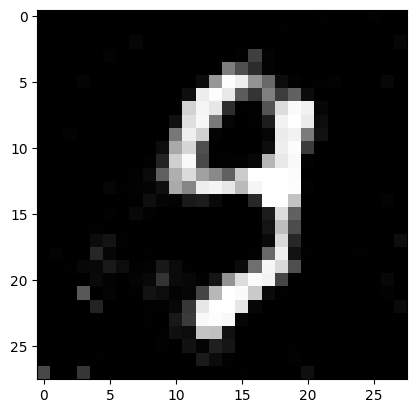

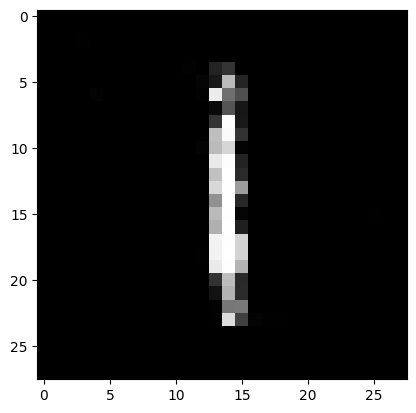

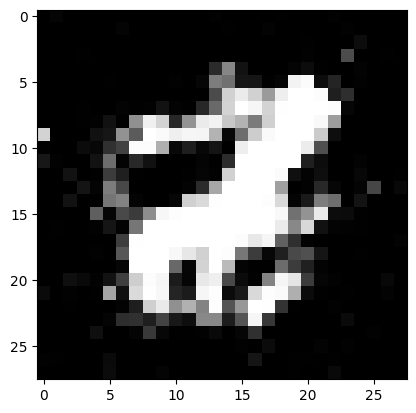

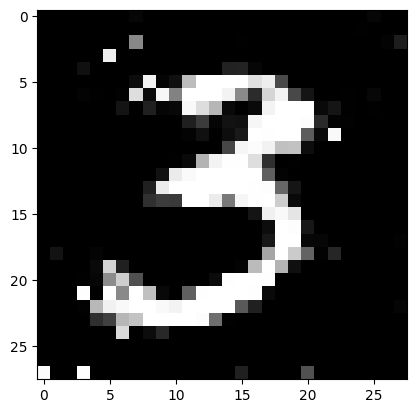

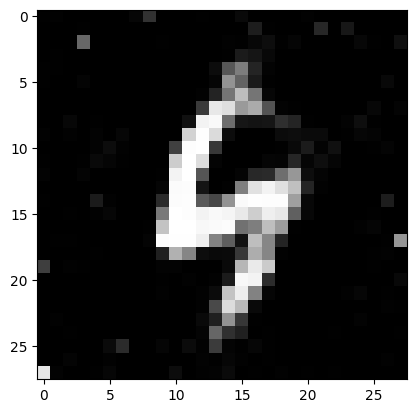

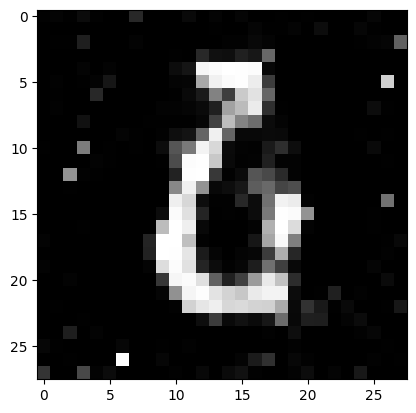

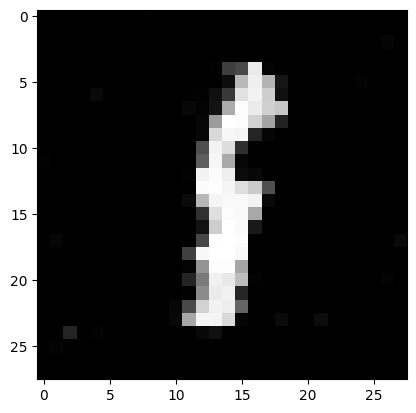

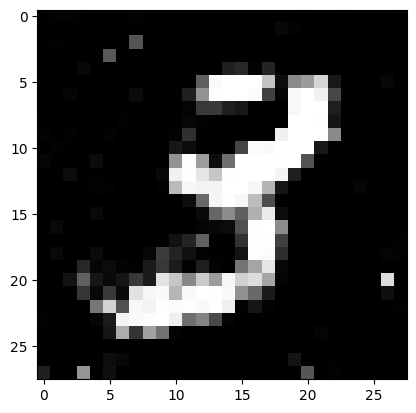

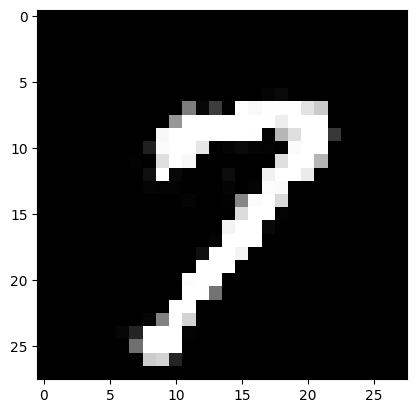

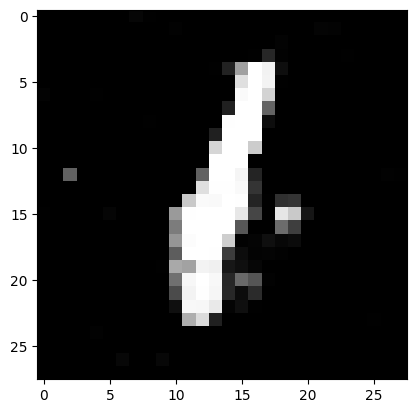

In [16]:
import numpy as np  #추가
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')    
    plt.show()